In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import illustris_python as il
import warnings

#### Halo selection criteria

In [2]:
halo_min_log = 10. # lower mass limit of halo

### define paths and fields of interest

In [3]:
basePath = './fof_subhalo_z0/'  ### groupcat data files are in basePath/groups_099/
halo_fields = ['GroupFirstSub','GroupNsubs','Group_M_Mean200'] ### Halo fields of interest. Options for halo mass: 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_M_Crit200', 'Group_M_Crit500'
subhalo_fields = ['SubhaloFlag','SubhaloMass','SubhaloGrNr','SubhaloMassInRadType','SubhaloGasMetalFractions'] ### Subhalo fields. 'SubhaloMassInRadType' OR 'SubhaloMassInHalfRadType'
HI_column = 'm_hi_GD14_map' ### column of HI mass used; options are: 'm_hi_GD14_map', 'm_hi_GD14_vol', 'm_hi_GK11_map', 'm_hi_GK11_vol', 'm_hi_K13_map', 'm_hi_K13_vol', 'm_hi_L08_map', 'm_hi_S14_map', 'm_hi_S14_vol'

### load data for haloes and subhaloes

In [4]:
halos = il.groupcat.loadHalos(basePath,99,fields=halo_fields)
halos_id = np.arange(halos['count'])
subhalos = il.groupcat.loadSubhalos(basePath,99,fields=subhalo_fields)
h = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
f_h1h2 = h5py.File('hih2_galaxy_099.hdf5','r')

# Method 1: using HI masses from h1h2 catalog

#### 1.1 Get IDs of primary subhaloes from the gas supplementary catalog, then return the HI mass of those primary (central) subhaloes

In [5]:
flag = np.array(f_h1h2['is_primary'])
id_gas = np.array(f_h1h2['id_subhalo']).astype(np.int32)
id_gas_p = np.array(id_gas[np.where(flag==1.0)]).astype(np.int32)
m_h1_p = np.array(f_h1h2[HI_column][np.where(flag==1.0)]).astype(np.int32)

#### 1.2 proceed to select the primary subhaloes in the `subhalos` array 

In [6]:
sub_id = subhalos['SubhaloGrNr'][id_gas_p]
sub_tot_mass = subhalos['SubhaloMass'][id_gas_p]
sub_mass_rad = subhalos['SubhaloMassInRadType'][id_gas_p]

#### 1.3 perform a cross-match between the primary subhaloes and their parent haloes

In [7]:
subhalos_matched_ids, ind_halo, ind_sub = np.intersect1d(np.array(halos_id),np.array(sub_id), return_indices=True)
print('Number of central subhaloes with HI mass: %d' %subhalos_matched_ids.size)

Number of central subhaloes with HI mass: 27869


#### 1.4 return respective masses of the central (primary) subhaloes

In [8]:
gal_mass_hi = m_h1_p[ind_sub]
gal_tot_mass = sub_tot_mass[ind_sub]
gal_mass_rad = sub_mass_rad[ind_sub]

#### 1.5 convert masses into adequate units

In [9]:
gal_mass_gas  = gal_mass_rad[:,0] * 1e10 / h
gal_mass_dm   = gal_mass_rad[:,1] * 1e10 / h               # total mass of all DM particles in the subhalo
gal_mass_star = gal_mass_rad[:,4] * 1e10 / h
halo_m200 = halos['Group_M_Mean200'][ind_halo] * 1e10 / h  # M200 of parent halo

###### (Note: 0 = gas, 1 = DM, 2 unused, 3 = tracers, 4 = stars, 5 = BHs)

#### 1.6 apply halo selection criteria

In [10]:
halo_mass_min = 10**halo_min_log
gal_mass_star = gal_mass_star[halo_m200>halo_mass_min]
gal_mass_dm = gal_mass_dm[halo_m200>halo_mass_min]
gal_mass_gas = gal_mass_gas[halo_m200>halo_mass_min]
gal_mass_hi = gal_mass_hi[halo_m200>halo_mass_min]
halo_m200 = halo_m200[halo_m200>halo_mass_min]

#### 1.7 select desired/adequate masses column for components (especially for DM: `gal_mass_dm` OR `halo_m200`)

In [11]:
smass  = gal_mass_star  # stellar mass
gmass  = gal_mass_hi    # gas mass
dmmass = halo_m200      # DM halo mass

#### 1.8 plot results

<ipython-input-12-cffec8ec442e>:3: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(smass), np.log10(gmass/dmmass), s=10)
<ipython-input-12-cffec8ec442e>:3: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(smass), np.log10(gmass/dmmass), s=10)


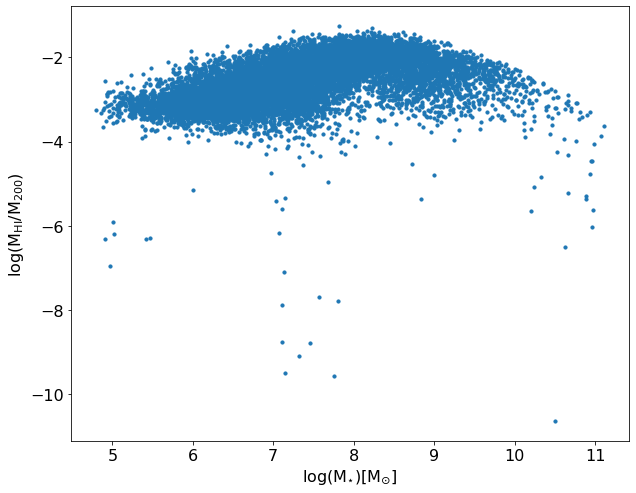

In [12]:
plt.rc('font', size=16)
plt.figure(figsize=(10,8))
plt.scatter(np.log10(smass), np.log10(gmass/dmmass), s=10)
plt.xlabel(r'$\rm log(M_{\star})[M_{\odot}]$')
plt.ylabel(r'$\rm log(M_{\rm HI}/M_{\rm 200})$');

# Method 2: compute HI masses
## (using subhaloes total mass and gas metal fraction [preliminary!])

#### 2.1 selecting central and satellite subhaloes
##### `cen` = central, `sat` = satellite

In [13]:
cen_sub = halos['GroupFirstSub']
cen_ids = cen_sub[cen_sub>=0] ### IDs of the central subhaloes (-1 means the halo has no subhalo so we exclude those)
cen_gn = subhalos['SubhaloGrNr'][cen_ids]  ### Parent halo IDs of the central subhaloes
mask = np.zeros(subhalos['count'], dtype=bool)
mask[cen_ids] = True
all_sub_ids = np.arange(subhalos['count'])
sat_ids = all_sub_ids[~mask]
sat_gn = subhalos['SubhaloGrNr'][sat_ids]
sat_flag = subhalos['SubhaloFlag'][sat_ids]
print('Number of central subhaloes: %d\nNumber of satellite subhaloes: %d\nNUmber of flagged subhaloes (non-cosmological origin): %d' \
      %(cen_ids.size,sat_flag[sat_flag==True].size,sat_flag[sat_flag==False].size))

Number of central subhaloes: 4462345
Number of satellite subhaloes: 1224424
NUmber of flagged subhaloes (non-cosmological origin): 1344


#### 2.2 extracting desired masses

##### 2.2.1 masses of central subhaloes

In [14]:
mhalo_cen = halos['Group_M_Mean200'][cen_gn] * 1e10/h
msub_cen = subhalos['SubhaloMassInRadType'][cen_ids] * 1e10/h
gas_frac_cen = subhalos['SubhaloGasMetalFractions'][cen_ids]

##### 2.2.2 masses of satellite subhaloes

In [15]:
mhalo_sat = halos['Group_M_Mean200'][sat_gn] * 1e10/h
msub_sat = subhalos['SubhaloMassInRadType'][sat_ids] * 1e10/h
gas_frac_sat = subhalos['SubhaloGasMetalFractions'][sat_ids]

### Discarding the flagged subhaloes
mhalo_sat = mhalo_sat[sat_flag]
msub_sat = msub_sat[sat_flag]
gas_frac_sat = gas_frac_sat[sat_flag]

#### 2.3 applying halo mass selection criteria

In [16]:
### On central subhaloes
m200_cen = mhalo_cen[mhalo_cen>halo_mass_min]
mgal_cen = msub_cen[mhalo_cen>halo_mass_min]
gfrac_cen = gas_frac_cen[mhalo_cen>halo_mass_min]

### On satellite subhaloes
m200_sat = mhalo_sat[mhalo_sat>halo_mass_min]
mgal_sat = msub_sat[mhalo_sat>halo_mass_min]
gfrac_sat = gas_frac_sat[mhalo_sat>halo_mass_min]

#### 2.4 deriving the HI mass from the gas mass
##### (MHI = H_fraction * Mgas)

In [17]:
### For central subhaloes
mgas_cen, mstar_cen = mgal_cen[:,0], mgal_cen[:,4]
mhi_cen = gfrac_cen[:,0] * mgas_cen

### For satellite subhaloes
mgas_sat, mstar_sat = mgal_sat[:,0], mgal_sat[:,4]
mhi_sat = gfrac_sat[:,0] * mgas_sat

###### Note from simulation regarding gas metal fractions: H, He, C, N, O, Ne, Mg, Si, Fe, total (in this order). Each is the dimensionless ratio of the total mass in that species divided by the total gas mass, both restricted to gas cells within twice the stellar half mass radius. The tenth entry contains the 'total' of all other (i.e. untracked) metals.

#### 2.5 plotting results

<ipython-input-19-05f195f78253>:3: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(mstar_cen),np.log10(mhi_cen/m200_cen), s=10, color='k', label='central')
<ipython-input-19-05f195f78253>:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(mstar_sat),np.log10(mhi_sat/m200_sat), s=10, color='gray', alpha=0.3, label='satellite')


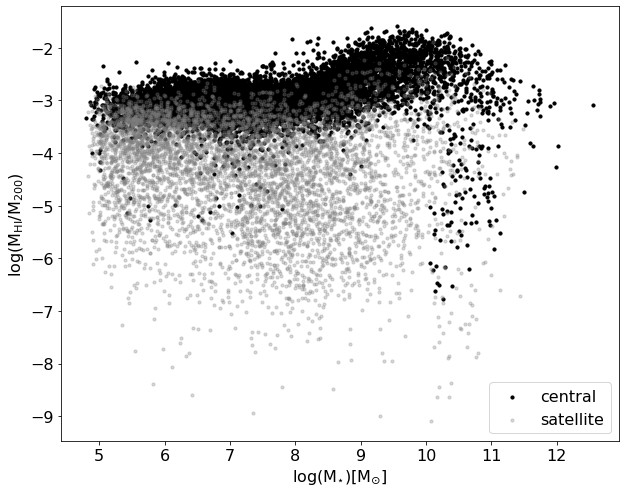

In [19]:
plt.rc('font', size=16)
plt.figure(figsize=(10,8))
plt.scatter(np.log10(mstar_cen),np.log10(mhi_cen/m200_cen), s=10, color='k', label='central')
plt.scatter(np.log10(mstar_sat),np.log10(mhi_sat/m200_sat), s=10, color='gray', alpha=0.3, label='satellite')
plt.xlabel(r'$\rm log(M_{\star})[M_{\odot}]$')
plt.ylabel(r'$\rm log(M_{\rm HI}/M_{\rm 200})$')
plt.legend(loc='best')
plt.show();

# 3. Comparing the two results

#### Compare the number of objects in each plot above (excluding the infinit log masses and mass ratios)

In [20]:
warnings.filterwarnings('ignore')
x_h1h2 = np.log10(smass); y_h1h2 = np.log10(gmass/dmmass)
mask_h1h2 = np.logical_or(np.isinf(x_h1h2), np.isinf(y_h1h2))
x_h1h2 = x_h1h2[~mask_h1h2]; y_h1h2 = y_h1h2[~mask_h1h2]

x_frac = np.log10(mstar_cen); y_frac = np.log10(mhi_cen/m200_cen)
mask_frac = np.logical_or(np.isinf(x_frac), np.isinf(y_frac))
x_frac = x_frac[~mask_frac]; y_frac = y_frac[~mask_frac]

print('Number of subhaloes in Method 1 plot: %d\nNumber of subhaloes in Method 2 plot: %d' %(x_h1h2.size,x_frac.size))

Number of subhaloes in Method 1 plot: 12785
Number of subhaloes in Method 2 plot: 12830


#### Overlaying the above two plots

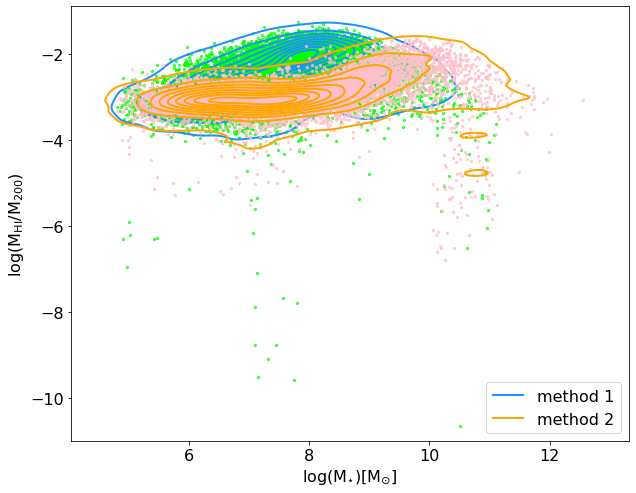

In [22]:
plt.rc('font', size=16)
fig, ax = plt.subplots(figsize=(10,8))

### Plot method 1 data (centrals)
plt.scatter(x_h1h2, y_h1h2, s=5, color='lime', alpha=0.7)
sns.kdeplot(x=x_h1h2, y=y_h1h2, ax=ax, fill=False, color='dodgerblue', levels=10, linewidths=2, thresh=0.02, zorder=1, label='method 1')

### Plot method 2 data (centrals)
plt.scatter(x_frac, y_frac, s=5, color='pink', alpha=0.7)
sns.kdeplot(x=x_frac,y=y_frac, ax=ax, fill=False, color='orange', levels=10, linewidths=2, thresh=0.02, zorder=2, label='method 2')
plt.xlabel(r'$\rm log(M_{\star})[M_{\odot}]$')
plt.ylabel(r'$\rm log(M_{\rm HI}/M_{\rm 200})$')
plt.legend(loc='lower right')
plt.show();